In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


import warnings
warnings.filterwarnings('ignore')

In [2]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from unicodedata import normalize
import spacy
nlp = spacy.load('es_core_news_sm')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Se inicia la limpieza y la vectorizacion del texto a usar para la prediccion. 
### Se agregan stopwords tipicos del lenguaje chileno y se reemplazan erroes ortograficos mas comunes  . 

In [3]:
stop_words = list(stopwords.words('spanish')) 
stop_words += [',', '.', ':', ';', '?', '!', '...', '(', ')', '…', 
               '”', '"', '-', '¿', '¡', 'rt', '`', 'si', "'", '/', 'hola', "tarde","martes", "lunes","miercoles", "jueves",
              "viernes","sabado", "domingo","enero","febrero","marzo","abril","mayo","junio","julio","agosto","septiembre",
               "octubre","noviembre","diciembre","manana","mañana","bnk","bacan","año","aser","chato","conchetumare","ctm",
               "chucha","choreado","chile","chileno","chao","hijo","hermano","hermana","hija","actual","agradeceria","mama",
              "papa"] 

In [4]:
def normalizando(text):
    s = re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", 
               r"\1",normalize( "NFD", text), 0, re.I) 
    s = normalize( 'NFC', s)
    doc = nlp(s)
    words = [t.lemma_.lower() for t in doc if not t.is_punct | t.is_stop]
    lexical_tokens = [t.lower() for t in words if len(t) > 2 and t.isalpha()]
    filtered_words =[w for w in lexical_tokens if not w in stop_words ]
    return list(np.unique(filtered_words))

In [5]:
def a_tex(review):
    text=""
    for n in range (0,(len(review))):
        if (review[n][:4]=="hola") or (review[n][:6]=="gracia")or (review[n][:2]=="bn")or (review[n][:3]=="ayu"):
            review[n]=""
        elif (review[n]=="mobil"):
            review[n]="movil"
        elif (review[n][:4]=="bloq"):
            review[n]="bloqueo"
        elif (review[n][:6]=="activa"):
            review[n]="activar"
        text=text+str(review[n])+" "
    return text  

In [6]:
datos=pd.read_csv("resolved_ok.csv")
datos.sample()

,text,intent
6258,necesito desbloquear un telefono para ser usad...,KGB_USARCELUFUERACHILE


In [9]:
corpus2 = []
for i in range(0, len(datos)):
    tokens = normalizando(datos['text'][i])
    tokens=a_tex(tokens)
    corpus2.append(tokens)

In [10]:
print("Oracion original: ",datos['text'][4])
print("Oracion normalizada: ",corpus2[4])

Oracion original:  me gustaria rebajar mi plan de telefonia mobil como lo hago 
Oracion normalizada:  gustaria movil plan rebajar telefonia 


En el siguiente grafico se puede observar que hay un porcentaje alto de opciones que no son de gran aporte para crear un modelo:


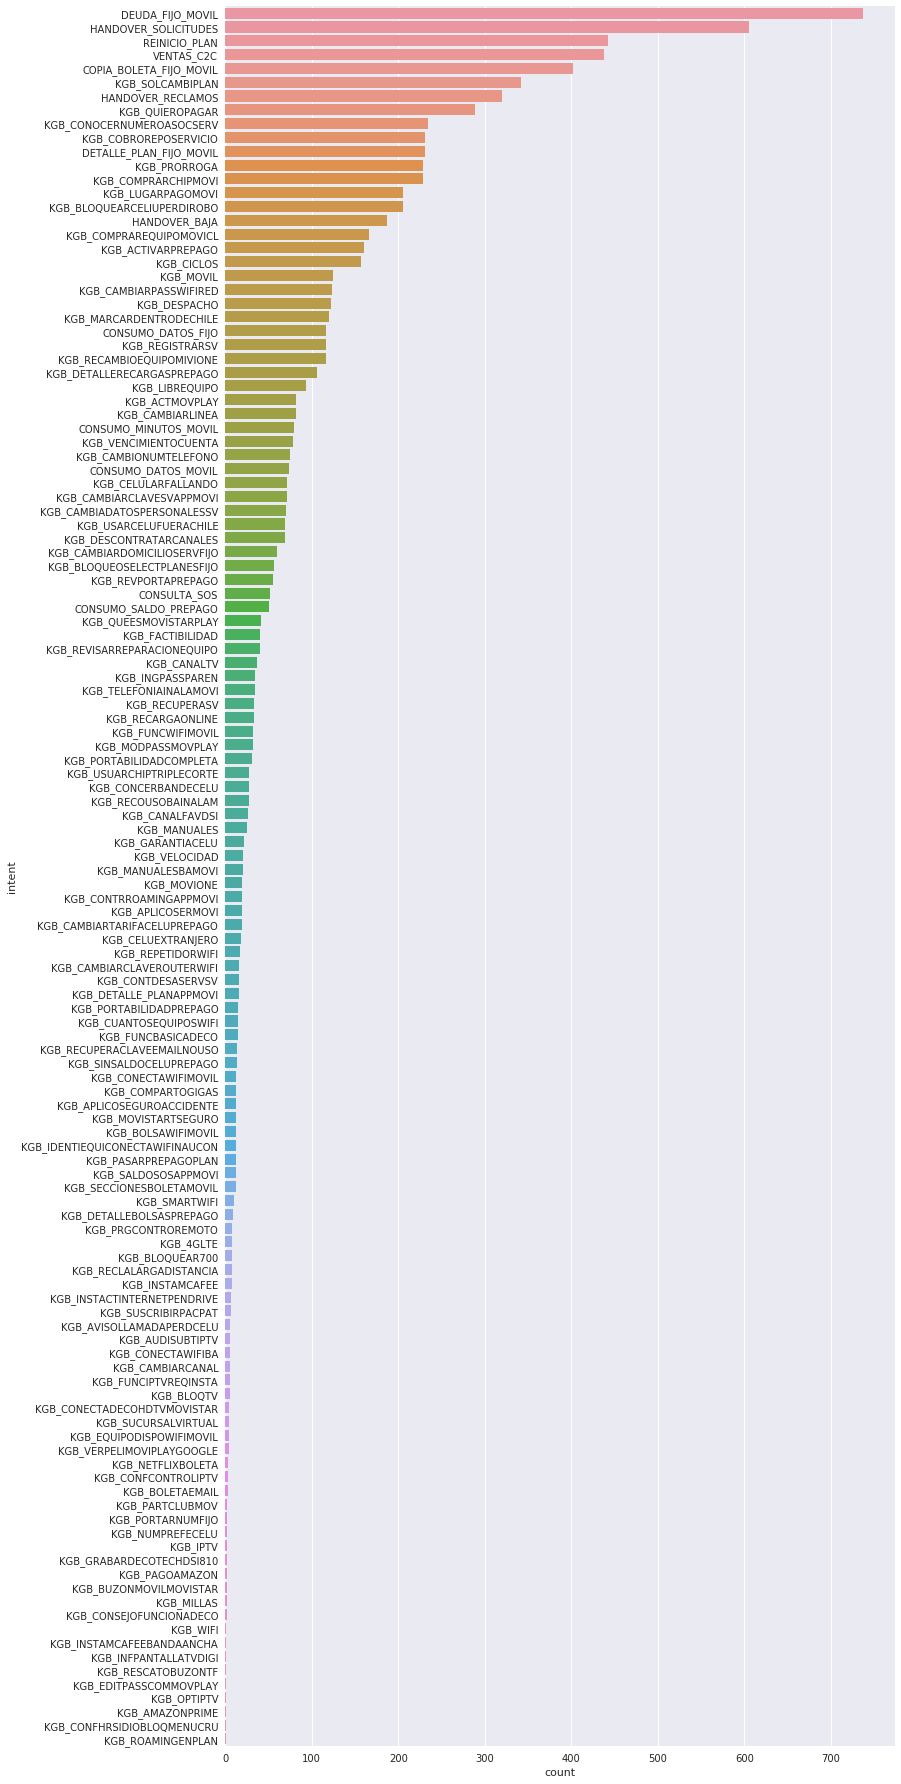

In [11]:
orden = list(datos["intent"].value_counts().reset_index()['index'])
fig,ax=plt.subplots(figsize=(12,32))
sns.countplot(y=datos["intent"],ax=ax, orient="v",order=orden)
print("En el siguiente grafico se puede observar que hay un porcentaje alto de opciones que no son de gran aporte para crear un modelo:")

## En esta visualizacion se observa que hay muchos intenten con poca aparicion que no aportan valor al modelo que se desee implementar. 
### Para mejorar la prediccion se acota a los intent que aprezcan mas de 50 veces. 

In [12]:
#Se definen las variables para crear el modelo
x=corpus2
y=datos.intent

In [13]:
#Se limpia la informacion para crear un modelo mas eficiente
conteo = pd.DataFrame(pd.Series.value_counts(y))
n=50
conteo = conteo[conteo.intent>n] #Entre mayor mas acertado el modelo. 
conteo.reset_index(inplace=True)
conteo.drop('intent', axis=1, inplace=True)
conteo.columns=['intent']
df = pd.DataFrame({'text':corpus2, 'intent': y})
df2 = pd.merge(df, conteo)
x = df2.text
y = df2.intent

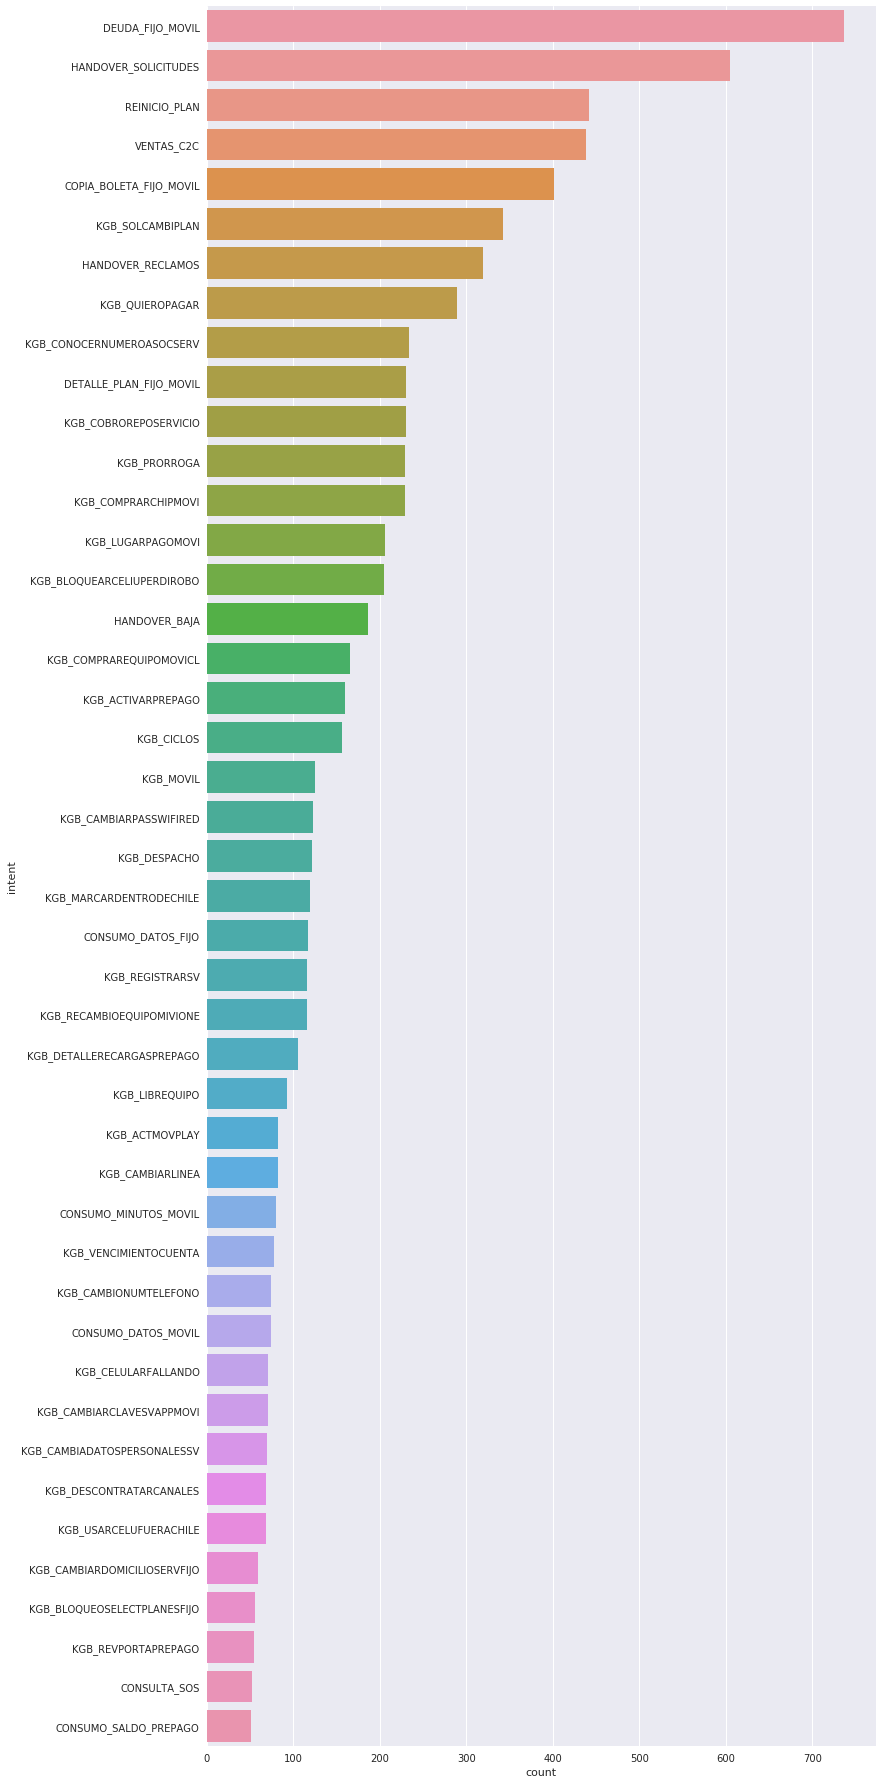

In [14]:
orden = list(df2["intent"].value_counts().reset_index()['index'])
fig,ax=plt.subplots(figsize=(12,32))
sns.countplot(y=df2["intent"],ax=ax, orient="v",order=orden)

In [15]:
print("El modelo se aplicara para ",len(df2.intent.unique()), "topicos de ",len(datos.intent.unique()))
print("Esto debido a que son los mas relevantes para las usuarios, siendo respuesta correcta en mas de ",n," veces en toda las interaciones.")

El modelo se aplicara para  44 topicos de  126
Esto debido a que son los mas relevantes para las usuarios, siendo respuesta correcta en mas de  50  veces en toda las interaciones.


### Vectorizamos nuestras oraciones normalizadas

In [16]:
#Vectorizamos nuestras oraciones normalizadas
from sklearn.feature_extraction.text import CountVectorizer
#vectorizer = TfidfVectorizer(ngram_range=(1,3))
vectorizer= CountVectorizer(ngram_range=(1,3))
#X = vectorizer.fit_transform(x).toarray()
X= vectorizer.fit_transform(x).toarray()
print(vectorizer.get_feature_names())

['abaratar', 'abaratar directamente', 'abaratar directamente oficina', 'abian', 'abian acabar', 'abian acabar minuto', 'abierta', 'abierta movistar', 'abierta movistar recuperar', 'abilitan', 'abilitan contratar', 'abilitan contratar plan', 'abiliten', 'abiliten bloqueo', 'abiliten bloqueo celular', 'ablar', 'ablar ejecutivo', 'ablar ejecutivo nesecito', 'able', 'able bajo', 'able bajo conmov', 'abonar', 'abonar cdf', 'abonar cdf celular', 'abonar colorir', 'abonar colorir llegar', 'abonar contar', 'abonar contar internet', 'abonar descontar', 'abonar descontar deuda', 'abrir', 'abrir actualizar', 'abrir actualizar aplicacion', 'abrir actualizar clavar', 'abrir algun', 'abrir algun alto', 'abrir atencion', 'abrir atencion local', 'abrir cerrar', 'abrir cerrar linear', 'abrir chip', 'abrir chip contratar', 'abrir chip dejar', 'abrir chip estara', 'abrir chip gustaria', 'abrir colocar', 'abrir colocar llamar', 'abrir concepcion', 'abrir concepcion cuidar', 'abrir concepcion sucursal', 'a

In [17]:
Y=LabelEncoder().fit_transform(y)

In [18]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.10,random_state=42)
model = MultinomialNB()
model.fit(Xtrain, ytrain)
y_pre = model.predict(Xtest)
mat  = confusion_matrix(ytest, y_pre)
print (accuracy_score(ytest, y_pre))

0.36981132075471695


In [19]:
X.shape

(7943, 29083)

In [20]:
print(classification_report(y_pre, ytest))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.22      1.00      0.36         2
           4       0.00      0.00      0.00         0
           5       0.11      0.17      0.14        23
           6       0.00      0.00      0.00         3
           7       0.74      0.27      0.40       195
           8       0.19      0.44      0.27         9
           9       0.14      0.26      0.18        19
          10       0.53      0.24      0.33       107
          11       0.33      0.45      0.38        11
          12       0.33      0.25      0.29         4
          13       0.83      0.67      0.74        30
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.29      0.50      0.36         4
          17       0.25    

### El modelo tiene una presicion del 56%, hay intent que tiene una precision y recall, lamentablemente la cantidad de datos no aportan para hacer un modelo mas acertado.